## Include required libararies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits import mplot3d
from datetime import datetime, date
from xgboost import XGBClassifier
from xgboost import plot_importance

## Load the Data

In [2]:
# Path to the csv file
dataPath = "./data/data.csv"

# Load the data
rawDataFrame = pd.read_csv(dataPath)

# Print some data
rawDataFrame.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [3]:
rawDataFrame.columns

Index(['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID',
       'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'DATE_OF_BIRTH',
       'EMPLOYMENT_TYPE', 'DISBURSAL_DATE', 'STATE_ID', 'EMPLOYEE_CODE_ID',
       'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG',
       'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE',
       'PERFORM_CNS_SCORE_DESCRIPTION', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
       'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT',
       'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
       'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
       'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT',
       'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
       'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES',
       'LOAN_DEFAULT'],
      dtype='object')

We can see that there are 233,154 datapoints in the total dataset.

## Drop Null Values

Now we can simply identify the columns that contain NULL values.

In [4]:
# Identify the features with more than 50% NULL Data
rawDataFrame.isna().sum(axis=0) # We use axis = 0 so the null values are counted column-wise

UNIQUEID                                  0
DISBURSED_AMOUNT                          0
ASSET_COST                                0
LTV                                       0
BRANCH_ID                                 0
SUPPLIER_ID                               0
MANUFACTURER_ID                           0
CURRENT_PINCODE_ID                        0
DATE_OF_BIRTH                             0
EMPLOYMENT_TYPE                        7661
DISBURSAL_DATE                            0
STATE_ID                                  0
EMPLOYEE_CODE_ID                          0
MOBILENO_AVL_FLAG                         0
AADHAR_FLAG                               0
PAN_FLAG                                  0
VOTERID_FLAG                              0
DRIVING_FLAG                              0
PASSPORT_FLAG                             0
PERFORM_CNS_SCORE                         0
PERFORM_CNS_SCORE_DESCRIPTION             0
PRI_NO_OF_ACCTS                           0
PRI_ACTIVE_ACCTS                

We see that the feature `EMPLOYMENT_TYPE` is the only column containing NULL Values. Now there can be 2 options that can be either to drop the entire `EMPLOYMENT_TYPE` feature or just drop the rows that contain the NULL values for this feature. Now due to the large number of total datapoints in the entire dataset (233,154), the amount of NULL values (7,661) is considerable low which is only `3.29%` so it is better to drop the rows instead of droping the whole column as it may contain information that can effect the target variable and losing 3% of the data is not that harmful because we have enough datapoints to generalize on.

In [5]:
# Drop rows with null values
print(f"Total Number of Datapoints before droping: {len(rawDataFrame)}")
nullDroppedDataframe = rawDataFrame.dropna()
print(f"Total Number of Datapoints after droping: {len(nullDroppedDataframe)}")
print(f"Total Number of Datapoints dropped: {len(rawDataFrame) - len(nullDroppedDataframe)}")

Total Number of Datapoints before droping: 233154
Total Number of Datapoints after droping: 225493
Total Number of Datapoints dropped: 7661


We see that those 7,661 rows are dropped. Great!

## Add a new Feature of Age

Now let's add a new `Age` feature and compute it using the current date.

In [6]:
# A simple function to get age based on the Date of Birth
def getAge(dateOfBirth):
    
    # Convert string to datetime object and get the date only as `strptime` returns the time as well 
    dateOfBirth = datetime.strptime(dateOfBirth, "%d-%m-%Y").date() # Format Code List can be found at: https://www.programiz.com/python-programming/datetime/strptime
    
    # Get the current date
    today = date.today()
    
    # Return the age by subtracting date of birth from current date
    # We will also consider the dob month and day
    # If the current date's month and day is less than the dob's month and day, we subtract an additional year.
    return today.year - dateOfBirth.year - ((today.month, today.day) < (dateOfBirth.month, dateOfBirth.day))

# Apply the `getAge` method on the entire `DATE_OF_BIRTH` column and create a new feature age    
ageDataframe = nullDroppedDataframe['DATE_OF_BIRTH'].apply(getAge)

# Add the new `AGE` feature in our dataframe next to `DATE_OF_BIRTH`
# Get the Index of `DATE_OF_BIRTH` column in data frame
dateOfBirthColumnIndex = nullDroppedDataframe.columns.get_loc('DATE_OF_BIRTH')

# Add `AGE` column next to `DATE_OF_BIRTH` column
nullDroppedDataframe.insert(dateOfBirthColumnIndex + 1, "AGE", ageDataframe)

# Print the head of Dataframe to see the new feature
nullDroppedDataframe.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,AGE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,37,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,35,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,35,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,27,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,43,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


We see that the `Age` Feature has been added next to `DATE_OF_BIRTH` successfuly.

## 1: Feature Correlation with Target Variable

First step is to see how many features are `categorical` in nature. The features that are `categorical` should be converted to numerical features first before measuring the correlation.

In [7]:
# Let's find out the names of the columns that are Categorical in nature

# All column names
allColumns = nullDroppedDataframe.columns

# Column names that only contain numeric data
numericColumns = nullDroppedDataframe._get_numeric_data().columns

# Columns that contain categorical data
nonNumericFeatures = list(set(allColumns) - set(numericColumns))

# Let's see the non Numeric Features
nullDroppedDataframe[nonNumericFeatures].head()

,DISBURSAL_DATE,CREDIT_HISTORY_LENGTH,EMPLOYMENT_TYPE,AVERAGE_ACCT_AGE,PERFORM_CNS_SCORE_DESCRIPTION,DATE_OF_BIRTH
0,03-08-2018,0yrs 0mon,Salaried,0yrs 0mon,No Bureau History Available,01-01-1984
1,26-09-2018,1yrs 11mon,Self employed,1yrs 11mon,I-Medium Risk,31-07-1985
2,01-08-2018,0yrs 0mon,Self employed,0yrs 0mon,No Bureau History Available,24-08-1985
3,26-10-2018,1yrs 3mon,Self employed,0yrs 8mon,L-Very High Risk,30-12-1993
4,26-09-2018,0yrs 0mon,Self employed,0yrs 0mon,No Bureau History Available,09-12-1977


In [8]:
# Let's also find the Unique category values for categorical Variables
uniqueDf = nullDroppedDataframe[nonNumericFeatures].nunique().to_frame().reset_index()
uniqueDf.columns = ['Variable', 'Distinct Count']
uniqueDf

,Variable,Distinct Count
0,DISBURSAL_DATE,84
1,CREDIT_HISTORY_LENGTH,291
2,EMPLOYMENT_TYPE,2
3,AVERAGE_ACCT_AGE,192
4,PERFORM_CNS_SCORE_DESCRIPTION,20
5,DATE_OF_BIRTH,14417


We can observe the from all 6 of these `categorical variables` it only makes sence to use `EMPLOYMENT_TYPE` for our analysis purposes as all other features are simply dates or having too many categories. 

So let's just drop the irrelevant columns and convert Categorical Columns to Numeric columns. For this purpose we can go with Pandas `.astype('category').cat.codes`.

In [9]:
# Drop the non required features
processedDataFrame = nullDroppedDataframe.drop(['AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'DATE_OF_BIRTH', 'DISBURSAL_DATE', 'PERFORM_CNS_SCORE_DESCRIPTION'], axis=1)

# Convert Categorical Features to Numerical Feature
processedDataFrame['EMPLOYMENT_TYPE'] = processedDataFrame['EMPLOYMENT_TYPE'].astype('category').cat.codes
processedDataFrame.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,AGE,EMPLOYMENT_TYPE,...,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,37,0,...,0,0,0,0,0,0,0,0,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,35,1,...,0,0,0,0,1991,0,0,1,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,35,1,...,0,0,0,0,0,0,0,0,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,27,1,...,0,0,0,0,31,0,0,0,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,43,1,...,0,0,0,0,0,0,0,0,1,1


So we have got ridden on `Non-Numeric` data from our dataset and we now only have `Numeric` data. Great!

Now let's start the analysis by calculating feature correlations. For this purpose we can use a heatmap to get an idea of the features with each other.

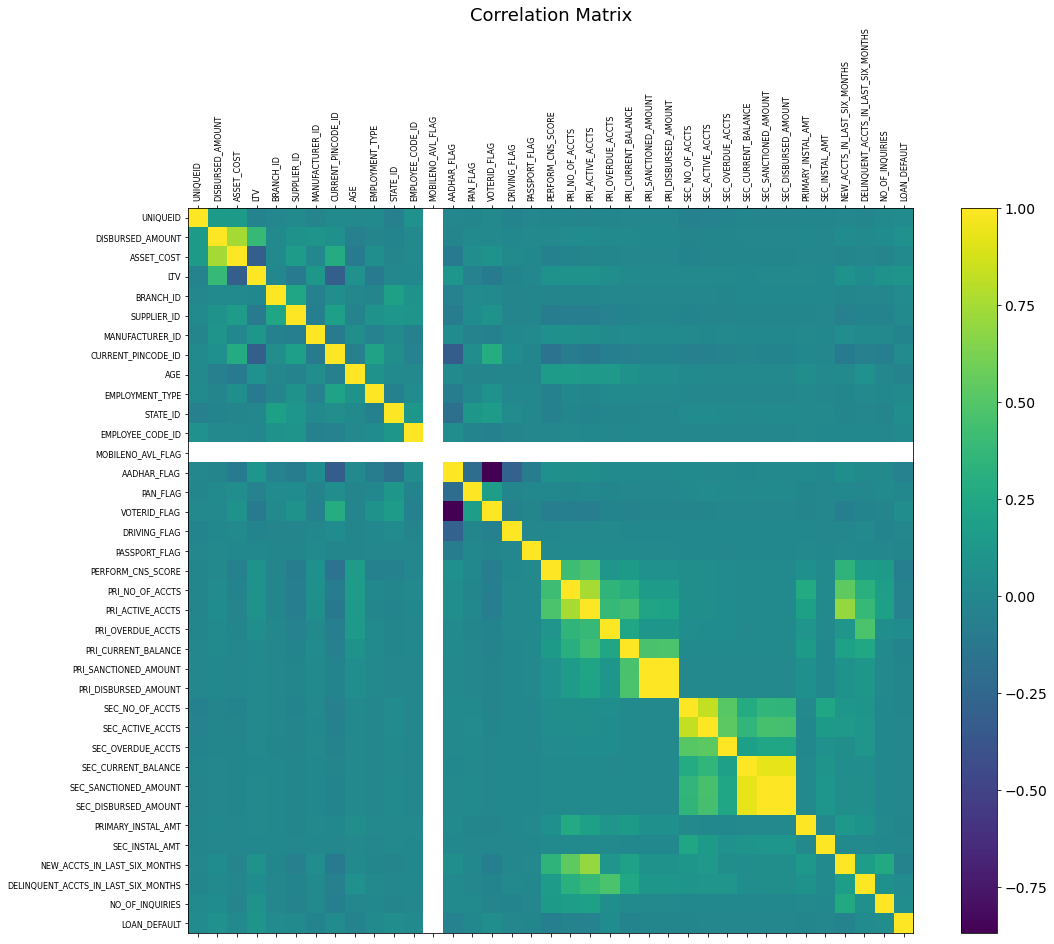

In [10]:
# Calculate Feature Correlation Matrix
featureCorrelationMatrix = processedDataFrame.corr()

# Plot Heatmap using the Correlation Matrix
f = plt.figure(figsize=(17, 13))
plt.matshow(featureCorrelationMatrix, fignum=f.number)
plt.xticks(range(processedDataFrame.select_dtypes(['number']).shape[1]), processedDataFrame.select_dtypes(['number']).columns, fontsize=8, rotation=90)
plt.yticks(range(processedDataFrame.select_dtypes(['number']).shape[1]), processedDataFrame.select_dtypes(['number']).columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=18);

In [11]:
# Check the correlation against the target Variable
correlationTarget = abs(featureCorrelationMatrix['LOAN_DEFAULT'])

# Selecting Features with positive correltaion
featuresOfInterest = correlationTarget[correlationTarget > 0].sort_values()
featuresOfInterest

SEC_INSTAL_AMT                         0.001453
SEC_OVERDUE_ACCTS                      0.001482
PAN_FLAG                               0.002079
SEC_CURRENT_BALANCE                    0.005528
DRIVING_FLAG                           0.005575
SEC_ACTIVE_ACCTS                       0.006088
SEC_DISBURSED_AMOUNT                   0.006277
SEC_SANCTIONED_AMOUNT                  0.006384
PASSPORT_FLAG                          0.007841
SEC_NO_OF_ACCTS                        0.008494
PRIMARY_INSTAL_AMT                     0.010386
PRI_DISBURSED_AMOUNT                   0.011118
PRI_SANCTIONED_AMOUNT                  0.011273
ASSET_COST                             0.015620
EMPLOYEE_CODE_ID                       0.020903
MANUFACTURER_ID                        0.025594
PRI_CURRENT_BALANCE                    0.027517
SUPPLIER_ID                            0.027569
EMPLOYMENT_TYPE                        0.029089
CURRENT_PINCODE_ID                     0.029826
NEW_ACCTS_IN_LAST_SIX_MONTHS           0

These are the features that are positively correlated with the target variable, so we will continue with these features.

In [12]:
# Create a Positively Correlated Dataframe
positivlyCorrelatedDataframe = processedDataFrame[featuresOfInterest.index]
positivlyCorrelatedDataframe.head()

,SEC_INSTAL_AMT,SEC_OVERDUE_ACCTS,PAN_FLAG,SEC_CURRENT_BALANCE,DRIVING_FLAG,SEC_ACTIVE_ACCTS,SEC_DISBURSED_AMOUNT,SEC_SANCTIONED_AMOUNT,PASSPORT_FLAG,SEC_NO_OF_ACCTS,...,PRI_OVERDUE_ACCTS,PRI_ACTIVE_ACCTS,AADHAR_FLAG,NO_OF_INQUIRIES,VOTERID_FLAG,STATE_ID,PERFORM_CNS_SCORE,DISBURSED_AMOUNT,LTV,LOAN_DEFAULT
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,6,0,50578,89.55,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,6,598,47145,73.23,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,6,0,53278,89.63,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,6,305,57513,88.48,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,6,0,52378,88.39,1


## 2: Demographic Data Impact

## 3: Features for feature analysis

Feature that are more than 0.02 correlation can be used for feature analysis as they have a higher imapct on the target variable.

In [13]:
featAnalysisFeatures = correlationTarget[correlationTarget > 0.02].sort_values()
featAnalysisFeatures

EMPLOYEE_CODE_ID                       0.020903
MANUFACTURER_ID                        0.025594
PRI_CURRENT_BALANCE                    0.027517
SUPPLIER_ID                            0.027569
EMPLOYMENT_TYPE                        0.029089
CURRENT_PINCODE_ID                     0.029826
NEW_ACCTS_IN_LAST_SIX_MONTHS           0.030113
BRANCH_ID                              0.030500
UNIQUEID                               0.033666
DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS    0.034507
AGE                                    0.034939
PRI_NO_OF_ACCTS                        0.035954
PRI_OVERDUE_ACCTS                      0.040926
PRI_ACTIVE_ACCTS                       0.042311
AADHAR_FLAG                            0.043455
NO_OF_INQUIRIES                        0.043844
VOTERID_FLAG                           0.045778
STATE_ID                               0.050032
PERFORM_CNS_SCORE                      0.059730
DISBURSED_AMOUNT                       0.079286
LTV                                    0

We can also use XGBoostClassifier to know the feature importance.

In [14]:
# Separate Dependent and Independent Varibale
X = positivlyCorrelatedDataframe[featAnalysisFeatures.index].iloc[:, :-1]
y = positivlyCorrelatedDataframe[featAnalysisFeatures.index].iloc[:, -1]

[01:08:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


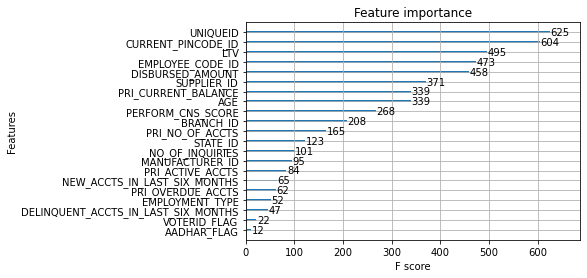

In [15]:
# We can also use `XGBoostClassifier` to check feature importance

# Train XGBClassifier with our X, y
model = XGBClassifier(use_label_encoder=False)
model.fit(X, y)

# plot feature importance
plot_importance(model)
plt.show()

Let's get features that have f-score more than 300

In [16]:
# Get features that have `F-Score` more than 300
X = positivlyCorrelatedDataframe[['UNIQUEID', 'CURRENT_PINCODE_ID', 'LTV', 'EMPLOYEE_CODE_ID', 'DISBURSED_AMOUNT', 'SUPPLIER_ID', 'PRI_CURRENT_BALANCE', 'AGE']].iloc[:, :-1]

## 4: Estimator Recommendation

As we have too many features and it is not able to visualize them in 22 dimensions, we can use `PCA(Principle Component Analysis)` for dimentionality reduction. We use PCA with 2 components so we get two features in return. 

In [17]:
from sklearn.decomposition import PCA

In [18]:
# Ready the PCA
pca = PCA(n_components=2).fit_transform(X, y)

# Get feat1 and feat2
feat1, feat2 = pca[:, 0], pca[:, 1]

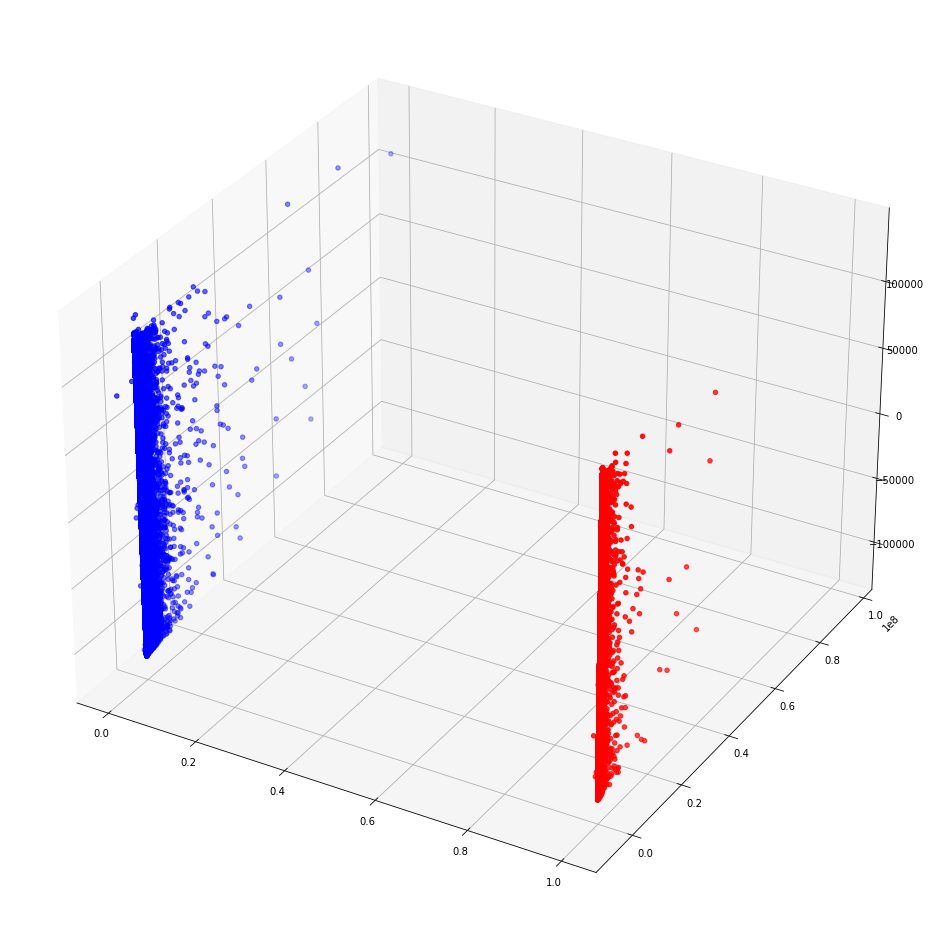

In [19]:
# Plot in 3 Dimensions. 2 Dimensions will be the features and the 3rd dimension will be the target
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(19, 17)
zline = y
xline = feat1
yline = feat2
ax.scatter3D(zline, xline, yline, c=y.values, cmap=matplotlib.colors.ListedColormap(['blue', 'red']));
loc = np.arange(0,max(y.values),max(y.values)/float(2))
cb.set_ticks(loc)
cb.set_ticklabels(['blue', 'red'])

We can see that there is a perfect gap between the 2 classes. So we can use 

## Supervised Learning
##### 1) Deep Neural Network with a Single output Neuron with Softmax activation
##### 2) Logistic Regression
##### 3) Naive Bays
##### 4) SVM (Support Vector Machine)
##### 5) Decision Trees 


In [ ]:
X